In [4]:
using Turing, Plots, StatsPlots, Distributions
using Random
using DataFrames, CSV, HTTP
using LinearAlgebra
Random.seed!(1345);

In [62]:
function tanh_network(x, a, b) 
    sum(a .* tanh.(b .* x))
end;

In [185]:
σ = 0.1
N = 1
M = 1
Hₒ = 1
H = 1
num_train = 500

Aₒ = rand(Normal(0, 1), (Hₒ, M))
Bₒ = rand(Normal(0, 1), (M, Hₒ))
X = rand(MvNormal(zeros(M), 3^2 * diagm(ones(M))), num_train)
μ = Bₒ * Aₒ * X
y = hcat([rand(MvNormal(μ[:, i], σ^2 * diagm(ones(N))), 1) for i in 1:num_train]...)

@show Aₒ
@show Bₒ
size(X), size(y)

Aₒ = [-0.9905980523216645]
Bₒ = [1.6557337304609594]


((1, 500), (1, 500))

In [186]:
@model reduced_rank_reg(X, y; H=H, M=M, N=N, σ=σ) = begin
    a ~ MvNormal(zeros(H * M), 100 * I)
    A = reshape(a, H, M)
    b ~ MvNormal(zeros(H * N), 100 * I)
    B = reshape(a, N, H)
    for i ∈ 1:num_train
        y[:, i] ~ MvNormal(B * A * X[:, i], σ * I)
    end
end;

In [191]:
model = reduced_rank_reg(X, y)
chain = sample(model, NUTS(), 10000)

┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/edmund/.julia/packages/Turing/y0DW3/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:04


In [192]:
#summarize(chain[1000:end])
chain

Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 84.11 seconds
Compute duration  = 84.11 seconds
parameters        = a[1], b[1]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        a[1]    0.0000    0.0027     0.0000    0.0000   7887.3435    0.9999    ⋯
        b[1]    0.0088   10.0371     0.1004    0.1122   7637.9356    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol    Float64   Float64   Float64   Float64   Float64

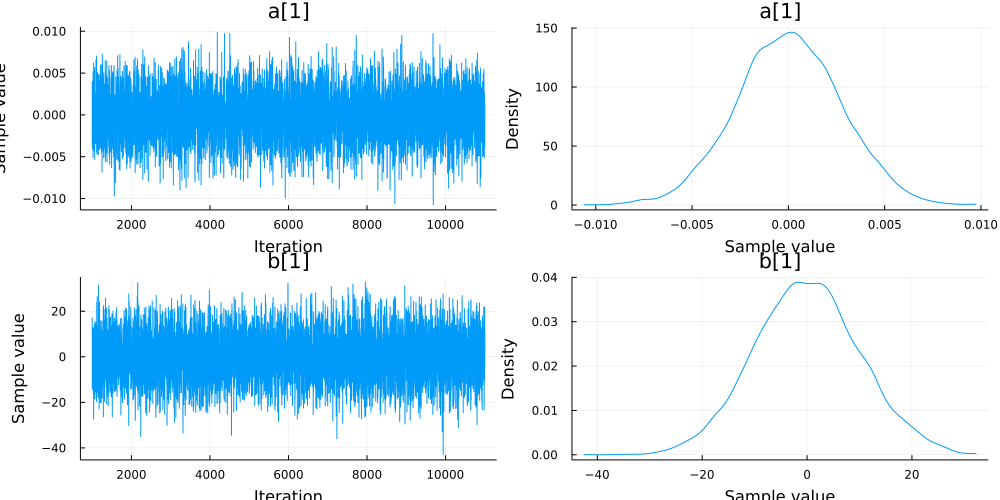

In [193]:
plot(chain)